## **EX1-Q3** ##

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, sampler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
def evaluate_loss(model, data, labels, loss_fn):
    """
    evaluate the loss
    """
    predicted = model(data)
    errors = loss_fn(predicted, labels)
    return float(errors)

def plot_faces(axes, img_indxs, model, shape):
    for ax, img_indx in zip(axes.reshape(-1), img_indxs):
        pred = ((model(X_val[img_indx].view(shape)) + 1) * 48).detach().numpy().reshape(15, 2)
        y_t = ((Y_val[img_indx] + 1) * 48).numpy().reshape(15, 2)
        ax.imshow(X_val[img_indx].numpy().reshape(96, 96), cmap="gray")
        ax.scatter(pred[:, 0], pred[:, 1], color='r', s=20)
        ax.scatter(y_t[:, 0], y_t[:, 1], color='b', s=20)

def plot_loss(train_loss_lst, val_loss_lst, title):
    plt.plot(np.arange(len(train_loss_lst)), train_loss_lst, color='k', label='train')
    plt.plot(np.arange(len(val_loss_lst)), val_loss_lst, color='g', label='validation')
    plt.legend()
    plt.title(title)
    plt.xlabel('epoch[#]')
    plt.ylabel('loss')
    plt.show()

def train(model, epochs, loader, loss_fn, optimizer, scheduler, X_val, Y_val):
    train_loss = []
    val_loss = []
    train_loss.append(evaluate_loss(model, X_train, Y_train, loss_fn))
    val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
    for e in range(1,epochs + 1):
        print("-------------------------------")
        print(f"epoch #{e}")
        batches_loss = []
        for t, (x, y) in enumerate(loader):
            scheduler.step()
            model.train()
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            # forward pass
            y_pred = model(x)
            # Calculate Loss
            loss = loss_fn(y_pred, y)
            # optimization
            optimizer.zero_grad()
            # backward propagation
            loss.backward()
            # Updating parameters
            optimizer.step()
            batches_loss.append(loss.item())
            if t % print_every == 0:
                print(f'Iteration {t}, loss = {loss.item():.4f}')
            
        train_loss.append(np.mean(np.array(batches_loss)))
        val_loss.append(evaluate_loss(model, X_val, Y_val, loss_fn))
        print(f'loss = {np.mean(np.array(batches_loss)):.4f} val_loss = {evaluate_loss(model, X_val, Y_val, loss_fn):.4f}')
        
    return train_loss, val_loss

class View(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [4]:
C = 1
L = 96
W = 96
flatten_dim = L * W
output_dim = 30
h = 100
val_precenteg = 0.15
BATCH_SIZE = 50
print_every = 15

### **Load data**

In [5]:
# loading data
data_frame = pd.read_csv('training.csv', sep=',').dropna()
Y = (data_frame.iloc[:, 0:-1].values / 48) - 1

img_df = data_frame.iloc[:, -1]

img_df.to_csv('.img.csv', index=False)
X = pd.read_csv('.img.csv', sep=' ', header=None).values / 255
N = X.shape[0]

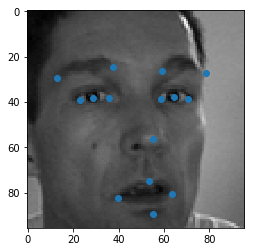

In [6]:
Y_t = ((Y + 1) * 48).reshape(-1, 15, 2)
plt.imshow(X[101].reshape(96, 96), cmap="gray")
plt.scatter(Y_t[101, :, 0], Y_t[101, :, 1])
plt.show()

### **Fully connected neural network**

In [7]:
mask = np.arange(0, N)
np.random.shuffle(mask)
val_mask = mask[:int(X.shape[0] * val_precenteg)]
train_mask = mask[int(X.shape[0] * val_precenteg):]
X_val = torch.FloatTensor(X[val_mask]).to(device=device)
X_train = torch.FloatTensor(X[train_mask]).to(device=device)
Y_val = torch.FloatTensor(Y[val_mask]).to(device=device)
Y_train = torch.FloatTensor(Y[train_mask]).to(device=device)

print(X_train.shape)

torch.Size([1819, 9216])


In [8]:
train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [9]:
linear_model = torch.nn.Sequential(nn.Linear(flatten_dim, h), nn.ReLU(), nn.Linear(h, output_dim))

In [10]:
fc_train_loss_lst, fc_val_loss_lst = [], []
loss_fn = F.mse_loss

optimizer = optim.SGD(linear_model.parameters(), lr=5e-1)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [11]:
loss = train(linear_model, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)
fc_train_loss_lst += loss[0]
fc_val_loss_lst += loss[1]

-------------------------------
epoch #1
Iteration 0, loss = 0.1498
Iteration 15, loss = 0.2117
Iteration 30, loss = 0.0265
loss = 22.8297 val_loss = 0.0218
-------------------------------
epoch #2
Iteration 0, loss = 0.0205
Iteration 15, loss = 0.0269
Iteration 30, loss = 0.0197
loss = 0.0225 val_loss = 0.0214
-------------------------------
epoch #3
Iteration 0, loss = 0.0213
Iteration 15, loss = 0.0219
Iteration 30, loss = 0.0204
loss = 0.0223 val_loss = 0.0214
-------------------------------
epoch #4
Iteration 0, loss = 0.0214
Iteration 15, loss = 0.0254
Iteration 30, loss = 0.0195
loss = 0.0223 val_loss = 0.0214
-------------------------------
epoch #5
Iteration 0, loss = 0.0214
Iteration 15, loss = 0.0212
Iteration 30, loss = 0.0191
loss = 0.0223 val_loss = 0.0214
-------------------------------
epoch #6
Iteration 0, loss = 0.0262
Iteration 15, loss = 0.0260
Iteration 30, loss = 0.0213
loss = 0.0224 val_loss = 0.0214
-------------------------------
epoch #7
Iteration 0, loss = 0.

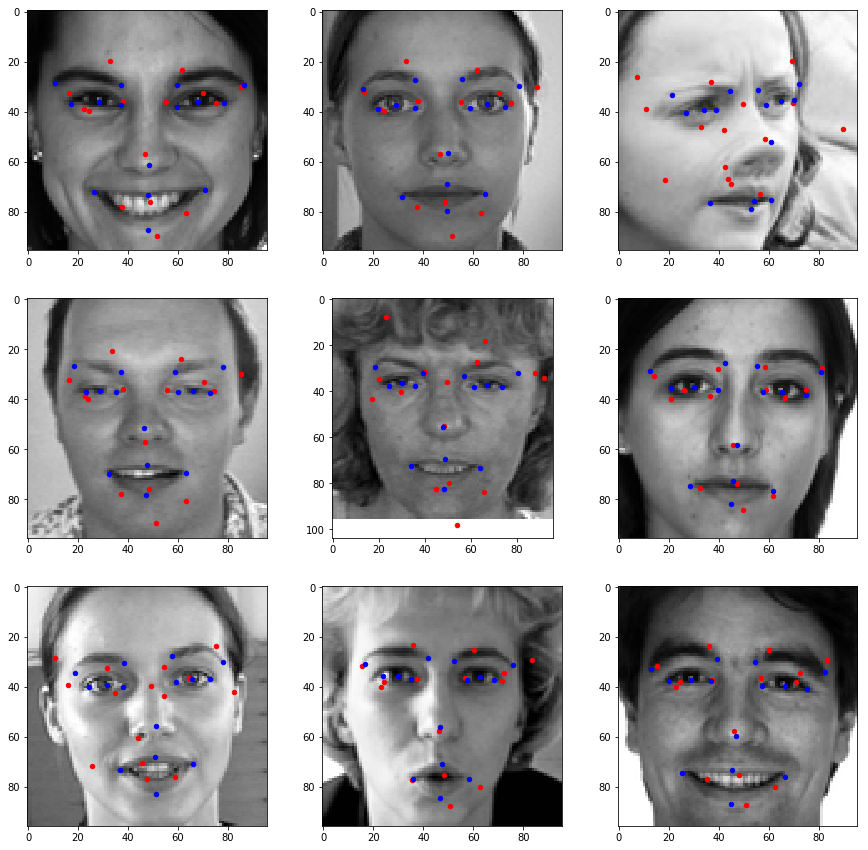

In [12]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * nrows, 5 * ncols))
imgs_indx = np.arange(Y_val.shape[0])
np.random.shuffle(imgs_indx)
plot_faces(ax, imgs_indx[:nrows * ncols], linear_model, (1, -1))
plt.show()

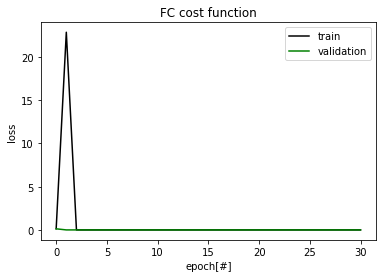

In [13]:
plot_loss(fc_train_loss_lst, fc_val_loss_lst,
         title='FC cost function')

### **Convolutional neural network**

In [14]:
X_val = X_val.view((-1, C, W, L)).to(device=device)
X_train = X_train.view((-1, C, W, L)).to(device=device)
print(X_train.shape)

torch.Size([1819, 1, 96, 96])


In [15]:
train_ds = TensorDataset(X_train, Y_train)
val_ds = TensorDataset(X_val, Y_val)
loader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler.SubsetRandomSampler(range(X_train.shape[0])))

In [16]:
conv_model = nn.Sequential(nn.Conv2d(1, 32, 3),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(32,64, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           nn.Conv2d(64, 128, 2),
                           nn.MaxPool2d(2),
                           nn.ReLU(),
                           View(),
                           nn.Linear(15488, 500),
                           nn.ReLU(),
                           nn.Linear(500, 500),
                           nn.ReLU(),
                           nn.Linear(500, output_dim)).to(device=device)

In [22]:
conv_train_loss_lst, conv_val_loss_lst = [], []

loss_fn = F.mse_loss

optimizer = optim.SGD(conv_model.parameters(), lr=7e-1, momentum=0.9, nesterov=True)

# Decay LR by a factor of 0.5 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [23]:
loss = train(conv_model, 30, loader_train, loss_fn, optimizer, exp_lr_scheduler, X_val, Y_val)
conv_train_loss_lst += loss[0]
conv_val_loss_lst += loss[1]

-------------------------------
epoch #1
Iteration 0, loss = 0.0053
Iteration 15, loss = 0.0039
Iteration 30, loss = 0.0049
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #2
Iteration 0, loss = 0.0058
Iteration 15, loss = 0.0042
Iteration 30, loss = 0.0041
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #3
Iteration 0, loss = 0.0052
Iteration 15, loss = 0.0043
Iteration 30, loss = 0.0048
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #4
Iteration 0, loss = 0.0034
Iteration 15, loss = 0.0044
Iteration 30, loss = 0.0039
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #5
Iteration 0, loss = 0.0035
Iteration 15, loss = 0.0045
Iteration 30, loss = 0.0044
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #6
Iteration 0, loss = 0.0044
Iteration 15, loss = 0.0047
Iteration 30, loss = 0.0052
loss = 0.0044 val_loss = 0.0043
-------------------------------
epoch #7
Iteration 0, loss = 0.0

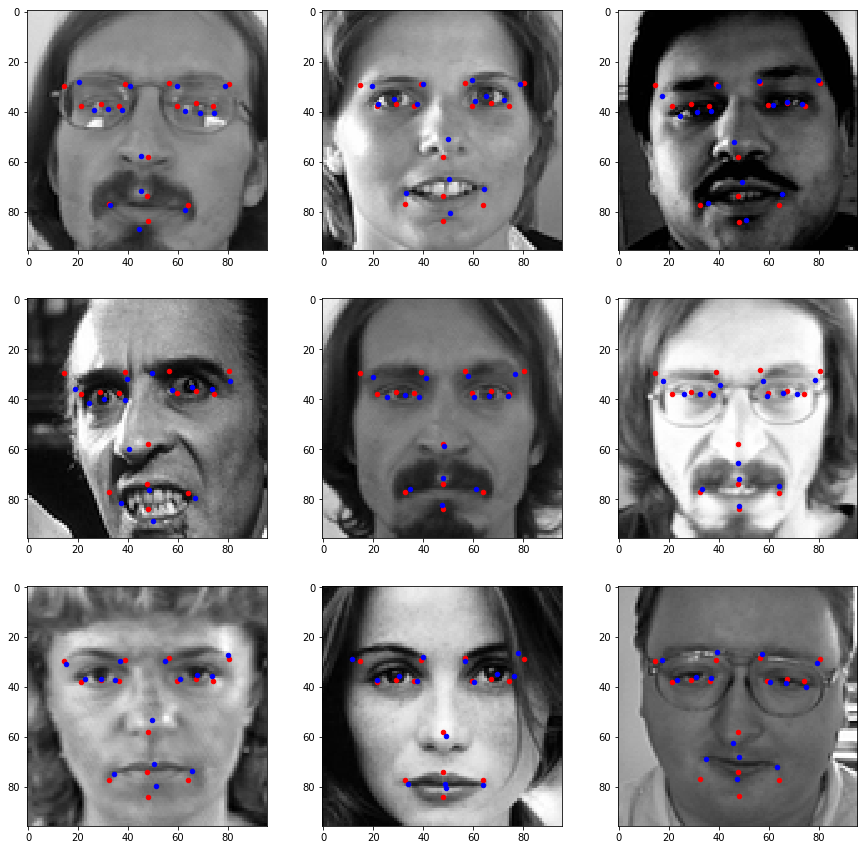

In [19]:
nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(5 * nrows, 5 * ncols))
imgs_indx = np.arange(Y_val.shape[0])
np.random.shuffle(imgs_indx)
plot_faces(ax, imgs_indx[:nrows * ncols],conv_model, (1, 1, 96, 96))
plt.show()

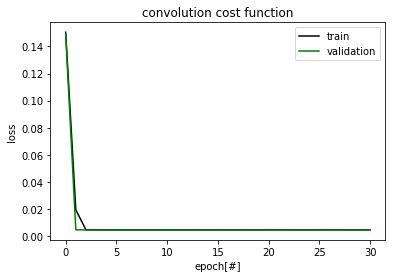

In [20]:
plot_loss(conv_train_loss_lst, conv_val_loss_lst, "convolution cost function")

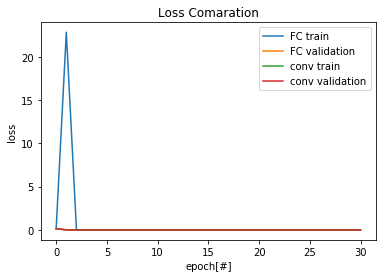

In [21]:
plt.plot(np.arange(len(fc_train_loss_lst)), fc_train_loss_lst, label='FC train')
plt.plot(np.arange(len(fc_val_loss_lst)), fc_val_loss_lst, label='FC validation')
plt.plot(np.arange(len(conv_train_loss_lst)), conv_train_loss_lst, label='conv train')
plt.plot(np.arange(len(conv_val_loss_lst)), conv_val_loss_lst, label='conv validation')

plt.legend()
plt.title("Loss Comaration")
plt.xlabel('epoch[#]')
plt.ylabel('loss')
plt.show()